In [2]:
import sys
import sklearn
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
from pathlib import Path

np.random.seed(42)
tf.random.set_seed(42)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
plt.style.use('seaborn-darkgrid')

# 특정 시점의 값 단일 예측

In [10]:
# 같은 길이(n_steps)의 시계열 데이터를 여러개(batch_size) 랜덤으로 생성하는 함수 
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)

In [11]:
# 길이 51의 시계열 1만개를 생성. 
# 50개로 훈련, 마지막 1개 값을 예측
n_steps = 50
series = generate_time_series(10000, n_steps + 1)
# train : valid : test = 7000 : 2000 : 1000
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

### 샘플 시계열 시각화

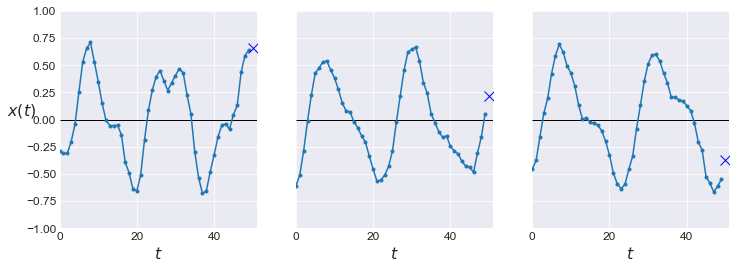

In [18]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize=10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None))
plt.show()

## baseline performance

In [12]:
# naive forecasting
y_pred = X_valid[:, -1]
print(np.mean(keras.losses.mean_squared_error(y_valid, y_pred)))

0.020918041


In [22]:
# FC network - linear regression model
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape = [50, 1]),
    keras.layers.Dense(1)
])

model.compile(loss = "mse", optimizer = "adam")
# history = model.fit(X_train, y_train, epochs = 20,
#                     validation_data = [X_valid, y_valid])

In [21]:
model.evaluate(X_test, y_test) # naive 예측보다 훨씬 좋음

1000/1000 [==============================] - 0s 27us/sample - loss: 0.0041


0.004064101088792085

## simple RNN

In [28]:
# 뉴런이 1개인 최소로 심플한 rnn
# 매 타임스텝마다 반복적으로 사용되는 input에 대한 가중치 Wx,
# hidden state에 대한 가중치 Wh, 편향 b => 총 3개의 파라미터
model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape = [None, 1])
])
model.compile(loss = "mse", optimizer = "adam")
# history = model.fit(X_train, y_train, epochs = 20,
#                     validation_data = [X_valid, y_valid])

In [27]:
model.evaluate(X_test, y_test) # naive 보단 좋지만 선형모델보다 않좋음

1000/1000 [==============================] - 0s 86us/sample - loss: 0.0131


0.013114856913685798

## Multi-layer RNN

In [47]:
# RNN은 셀을 여러 층으로 쌓는 것이 일반적이다.
# 여러 층을 쌓을 떄 모든 순환층에서 모든 time step의 출력을 내보내도록 설정해야한다. 
# (이후 층들에서 이용하기 위해)
model1 = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences = True, input_shape = [None, 1]),
    keras.layers.SimpleRNN(20, return_sequences = True),
    keras.layers.SimpleRNN(1)
])


# 사실 마지막층은 굳이 rnn으로 쌓을 필요 없음. dense로 바꾸는게 여러가지 이점이 있음
model2 = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences = True, input_shape = [None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(1)
])

model2.compile(loss = "mse", optimizer = "adam")
# history = model2.fit(X_train, y_train, epochs = 20,
#                     validation_data = [X_valid, y_valid])

In [33]:
model2.evaluate(X_test, y_test) # 선형모델보다 향상

1000/1000 [==============================] - 0s 152us/sample - loss: 0.0029


0.002945374183356762

# 여러 타임스텝 예측
1. 단일 예측값을 실 관측값처럼 간주, 반복적으로 input으로써 이용하는 방법
2. 한번에 여러 타임스텝 예측 

In [46]:
# 방법 1
np.random.seed(43)
n_steps = 50
series = generate_time_series(1, n_steps + 10)

# 과거 50개의 관측을 이용한 미래 10 STEP 값 예측 
X_new, Y_new = series[:, :n_steps], series[:, n_steps:]
X = X_new
for step_ahead in range(10):
    # sliding window
    y_pred_one = model2.predict(X[:, step_ahead:])[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:]

print(np.mean(keras.losses.mean_squared_error(Y_new, Y_pred)))

# 많은 step을 예측할 수록 오차가 누적되어 정확도가 떨어짐

0.012885684


In [60]:
# 방법 2
np.random.seed(42)
n_steps = 50
series = generate_time_series(10000, n_steps + 10)

# 타깃 - 10개 원소를 가진 벡터
X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

# 10개의 뉴런을 가진 출력층
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences = True, input_shape = [None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(10)
])

model.compile(loss = "mse", optimizer = "adam")
# history = model.fit(X_train, Y_train, epochs = 20,
#                     validation_data = [X_valid, Y_valid])

In [50]:
model.evaluate(X_test, Y_test)

1000/1000 [==============================] - 0s 148us/sample - loss: 0.0109


0.010912944033741951

In [63]:
# 방법 2의 개선 - 매 시점마다 이후 10 STEP의 값들을 예측하도록. (seq2seq)
# 각 시점의 input 1개에 10개 output이 매칭됨.
# 모든 step에서 RNN 출력에 대한 항이 손실에 포함되어 더 많은 오차 그레디언트가 모델로 흐름.
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train = series[:7000, :n_steps]
X_valid = series[7000:9000, :n_steps]
X_test = series[9000:, :n_steps]
# target sequence 준비
Y = np.empty((10000, n_steps, 10))
for step_ahead in range(1, 10 + 1):
    Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

np.random.seed(42)
tf.random.set_seed(42)

# 모든 time step에서 출력을 dense 층에 적용하기 위한 timedistributed 층
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

# 훈련시에는 모든 step의 출력이 필요하지만, 예측과 평가시에는 마지막 타임스텝의 출력만 사용 
def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

model.compile(loss="mse", optimizer=keras.optimizers.Adam(lr=0.01), metrics=[last_time_step_mse])
# history = model.fit(X_train, Y_train, epochs=20,
#                     validation_data=(X_valid, Y_valid))

In [62]:
model.evaluate(X_test, Y_test)

1000/1000 [==============================] - 0s 219us/sample - loss: 0.0194 - last_time_step_mse: 0.0086


[0.019441759645938875, 0.00861555]

방법 1과 방법 2를 결합하여 한번에 여러 step을 예측하고 그 예측값을 가지고있는 원본 시계열과  
concatenate하여 새로운 input 시퀀스로 사용할 수 있다.